In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
from scipy import stats

from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import RUSBoostClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [170]:
df_orig = pd.read_csv('uscecchini28.csv')
df = df_orig.copy()

In [171]:
df.tail(1)

,fyear,gvkey,sich,insbnk,understatement,option,p_aaer,new_p_aaer,misstate,act,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
146044,2014,317264,4412.0,0,0,0,NaN,NaN,0,233.211,...,0.068841,1.684618,-0.094348,0.020573,1,1.154308,0.745399,0.025562,0.026433,-0.240183


In [299]:
years = list(df.fyear.unique())
fraud_per_year = []

In [300]:
for year in years:
    fraud_per_year.append((df[df['fyear'] == year].groupby('gvkey').agg({'misstate':'sum'}).sum()/len(df[df['fyear'] == year].groupby('gvkey').agg({'misstate':'sum'}))*100))

In [301]:
np.mean(fraud_per_year)

0.6419889297735921

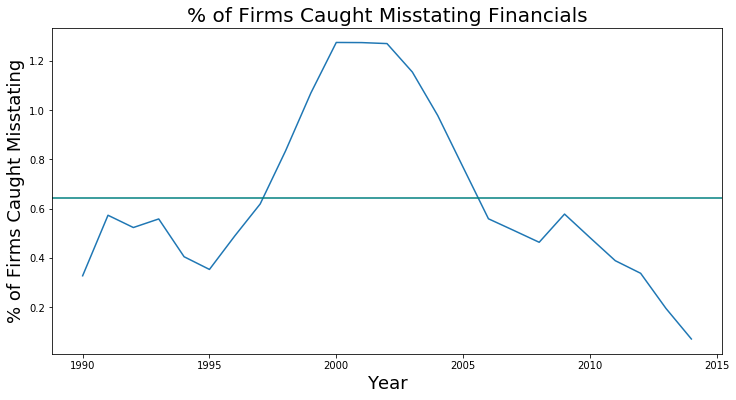

In [303]:
plt.figure(figsize=(12,6))
plt.plot(years, fraud_per_year)
plt.xlabel('Year', fontsize=18)
plt.ylabel('% of Firms Caught Misstating', fontsize=18)
plt.title('% of Firms Caught Misstating Financials', fontsize=20)
plt.axhline(y=np.mean(fraud_per_year), color='teal')
plt.show()

## Exploring Cases of Serial Fraud

In [173]:
df[df['gvkey'] == 1009]

,fyear,gvkey,sich,insbnk,understatement,option,p_aaer,new_p_aaer,misstate,act,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
0,1990,1009,3460.0,0,0,0,NaN,NaN,0,10.047,...,0.312448,0.095082,0.082631,-0.019761,1,0.413170,0.873555,0.167620,0.161961,-0.042140
4583,1991,1009,3460.0,0,0,0,NaN,NaN,0,12.911,...,0.363340,-0.111586,-0.187708,-0.041154,1,0.258828,0.859404,0.160184,0.105796,-0.023684
9295,1992,1009,3460.0,0,0,0,NaN,NaN,0,17.011,...,0.404588,0.451306,-0.101757,0.029666,1,0.209332,0.968396,0.159448,0.124309,0.014703
14265,1993,1009,3460.0,0,0,0,NaN,NaN,0,23.057,...,0.352267,0.348405,-0.319993,0.001852,1,0.161489,1.586663,0.149382,0.120162,-0.027630
19642,1994,1009,3460.0,0,0,0,1240.0,12401.0,1,33.796,...,0.358561,0.273430,0.272096,-0.001920,1,0.206075,1.132404,0.143619,0.115711,-0.039364


In [174]:
serial_series = df.groupby('gvkey')['misstate'].sum() > 1

In [175]:
serial_fraud_list = list(serial_series[serial_series == True].index)

In [176]:
len(serial_fraud_list)

230

## Preparing Train/Test Split by Fiscal Year

In [177]:
df.drop(columns=['dch_wc',
                 'ch_rsst',
                 'dch_rec',
                 'dch_inv',
                 'soft_assets',
                 'ch_cs',
                 'ch_cm',
                 'ch_roa',
                 'issue',
                 'bm',
                 'dpi',
                 'reoa',
                 'EBIT',
                 'ch_fcf'], inplace=True)

In [210]:
df_train = df[(df.fyear >= 1990) & (df.fyear <= 2006)]
df_train.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
print(df_train.shape)
df_train.misstate.value_counts()

(101501, 37)


0    100705
1       796
Name: misstate, dtype: int64

In [211]:
df_test = df[df.fyear > 2006]
df_test.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_test.shape)
df_test.misstate.value_counts()

(44544, 37)


0    44376
1      168
Name: misstate, dtype: int64

In [212]:
X = df_train.drop(columns=['fyear','gvkey','sich','insbnk','understatement','option','p_aaer','new_p_aaer','misstate'], axis = 1)
y = df_train.misstate

In [213]:
X2 = df_test.drop(columns=['fyear','gvkey','sich','insbnk','understatement','option','p_aaer','new_p_aaer','misstate'], axis = 1)
y2 = df_test.misstate

## Benchmark RUS AdaBoost Model

In [214]:
def RUS_AdaBoostClassifier_train(X, y, k_folds=10, random_state=42):
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    metrics_results = {}
    accuracy_list = []
    precision_list = []
    recall_list = []
    roc_auc_list = []
    TN_list = []
    FP_list = []
    FN_list = []
    TP_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fitting the model
        clf = RUSBoostClassifier()
        clf = clf.fit(X_train, y_train)

        y_test_predicted = clf.predict(X_test)
        y_test_predicted_prob = clf.predict_proba(X_test)

        #code for calculating accuracy 
        accuracy = accuracy_score(y_test, y_test_predicted, normalize=True)
        accuracy_list.append(accuracy)

        #code for calculating recall 
        recall = recall_score(y_test, y_test_predicted, average=None)
        recall_list.append(recall)

        #code for calculating ROC AUC score 
        roc_auc = roc_auc_score(y_test, y_test_predicted)
        roc_auc_list.append(roc_auc)

        #code for calculating precision 
        precision = precision_score(y_test, y_test_predicted, average=None)
        precision_list.append(precision)

        #code for calculating confusion matrix 
        confusion = confusion_matrix(y_test, y_test_predicted)
        TN_list.append(confusion[0][0])
        FP_list.append(confusion[0][1])
        FN_list.append(confusion[1][0])
        TP_list.append(confusion[1][1])

    # creating a metrics dictionary
    metrics_results['Accuracy'] = np.mean(accuracy_list)
    metrics_results['Precision'] = np.mean(precision_list, axis=0)
    metrics_results['Recall'] = np.mean(recall_list, axis=0)
    metrics_results['ROC AUC'] = np.mean(roc_auc_list, axis=0)
    metrics_results['TN'] = np.mean(TN_list)
    metrics_results['FP'] = np.mean(FP_list)
    metrics_results['FN'] = np.mean(FN_list)
    metrics_results['TP'] = np.mean(TP_list)
    sensitivity = metrics_results['TP']/(metrics_results['TP']+metrics_results['FN'])
    specificity = metrics_results['TN']/(metrics_results['TN']+metrics_results['FP'])

    print('\t\tAccuracy:', metrics_results['Accuracy'])
    print('\t\tPrecision:', metrics_results['Precision'])
    print('\t\tRecall:', metrics_results['Recall'])
    print('\t\tRoc AUC:', metrics_results['ROC AUC'])
    print('\t\tTrue Pos:', round(metrics_results['TP'], ndigits=0))
    print('\t\tFalse Pos:', round(metrics_results['FP'], ndigits=0))
    print('\t\tTrue Neg:', round(metrics_results['TN'], ndigits=0))
    print('\t\tFalse Neg:', round(metrics_results['FN'], ndigits=0))
    print('\t\tSensitivity:', sensitivity)
    print('\t\tSpecificity:', specificity)

    cm = [[metrics_results['TN'], metrics_results['FP']], [metrics_results['FN'], metrics_results['TP']]]
    plt.figure(figsize=(14,7))
    sns.heatmap(cm,  cmap= 'Reds', annot=True, fmt='1')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.show()

    return

		Accuracy: 0.7368598885887143
		Precision: [0.9950442  0.01651181]
		Recall: [0.73847431 0.53280063]
		Roc AUC: 0.6356374714832035
		True Pos: 42.0
		False Pos: 2634.0
		True Neg: 7437.0
		False Neg: 37.0
		Sensitivity: 0.5326633165829145
		Specificity: 0.738473759992056


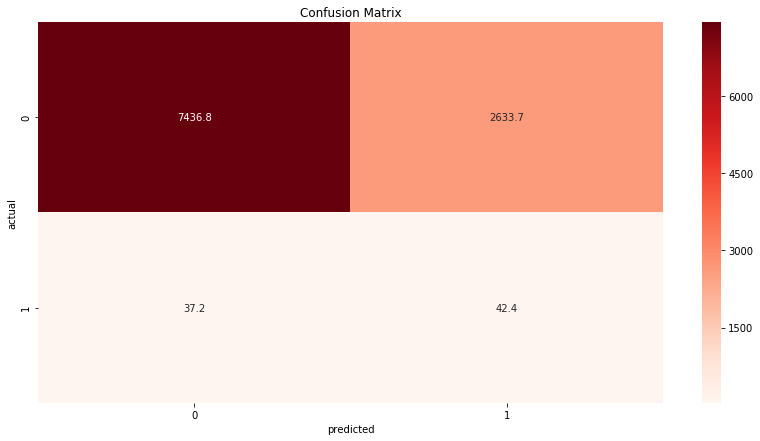

In [215]:
RUS_AdaBoostClassifier_train(X, y, k_folds=10, random_state=42)

## Compare Benchmark RUSBoost(Ada) Model to XGBoost w/ RUS

In [216]:
def RUS_XGBClassifier_train(X, y, k_folds=10, random_state=42):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    rus = RandomUnderSampler(random_state=random_state)

    metrics_results = {}
    accuracy_list = []
    precision_list = []
    recall_list = []
    roc_auc_list = []
    TN_list = []
    FP_list = []
    FN_list = []
    TP_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # undersampling each fold using Random Under Sampling with a class ratio of 1 to 1
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

        # fitting the model
        xgb_model = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=5,
                            min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                            objective='binary:logistic',nthread=4,scale_pos_weight=1)
        xgb_model = xgb_model.fit(X_train_res, y_train_res)

        y_test_predicted = xgb_model.predict(X_test)
        y_test_predicted_prob = xgb_model.predict_proba(X_test)

        #code for calculating accuracy 
        accuracy = accuracy_score(y_test, y_test_predicted, normalize=True)
        accuracy_list.append(accuracy)

        #code for calculating recall 
        recall = recall_score(y_test, y_test_predicted, average=None)
        recall_list.append(recall)

        #code for calculating ROC AUC score 
        roc_auc = roc_auc_score(y_test, y_test_predicted)
        roc_auc_list.append(roc_auc)

        #code for calculating precision 
        precision = precision_score(y_test, y_test_predicted, average=None)
        precision_list.append(precision)

        #code for calculating confusion matrix 
        confusion = confusion_matrix(y_test, y_test_predicted)
        TN_list.append(confusion[0][0])
        FP_list.append(confusion[0][1])
        FN_list.append(confusion[1][0])
        TP_list.append(confusion[1][1])

    # creating a metrics dictionary
    metrics_results['Accuracy'] = np.mean(accuracy_list)
    metrics_results['Precision'] = np.mean(precision_list, axis=0)
    metrics_results['Recall'] = np.mean(recall_list, axis=0)
    metrics_results['ROC AUC'] = np.mean(roc_auc_list, axis=0)
    metrics_results['TN'] = np.mean(TN_list)
    metrics_results['FP'] = np.mean(FP_list)
    metrics_results['FN'] = np.mean(FN_list)
    metrics_results['TP'] = np.mean(TP_list)
    sensitivity = metrics_results['TP']/(metrics_results['TP']+metrics_results['FN'])
    specificity = metrics_results['TN']/(metrics_results['TN']+metrics_results['FP'])

    print('\t\tAccuracy:', metrics_results['Accuracy'])
    print('\t\tPrecision:', metrics_results['Precision'])
    print('\t\tRecall:', metrics_results['Recall'])
    print('\t\tRoc AUC:', metrics_results['ROC AUC'])
    print('\t\tTrue Pos:', round(metrics_results['TP'], ndigits=0))
    print('\t\tFalse Pos:', round(metrics_results['FP'], ndigits=0))
    print('\t\tTrue Neg:', round(metrics_results['TN'], ndigits=0))
    print('\t\tFalse Neg:', round(metrics_results['FN'], ndigits=0))
    print('\t\tSensitivity:', sensitivity)
    print('\t\tSpecificity:', specificity)

    cm = [[metrics_results['TN'], metrics_results['FP']], [metrics_results['FN'], metrics_results['TP']]]
    plt.figure(figsize=(14,7))
    sns.heatmap(cm,  cmap= 'Reds', annot=True, fmt='1')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.show()

    return

		Accuracy: 0.7343575245322722
		Precision: [0.99778897 0.02304647]
		Recall: [0.73388637 0.79419304]
		Roc AUC: 0.7640397049883829
		True Pos: 63.0
		False Pos: 2680.0
		True Neg: 7391.0
		False Neg: 16.0
		Sensitivity: 0.7939698492462313
		Specificity: 0.7338861029740331


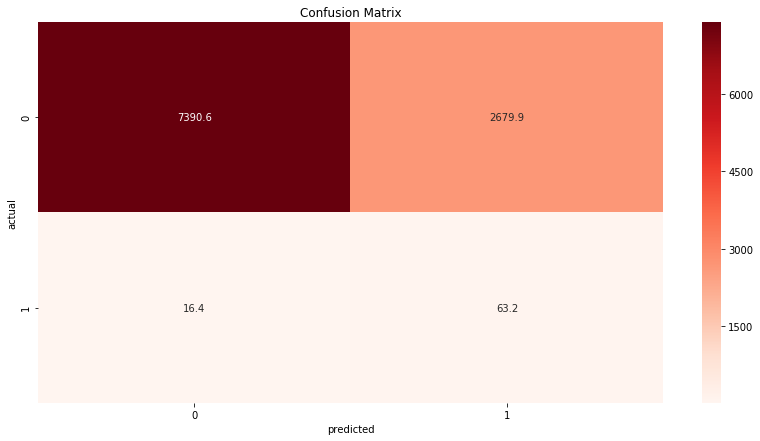

In [217]:
RUS_XGBClassifier_train(X,y,k_folds=10,random_state=42)

## Fit RUS AdaBoost Model

In [218]:
def RUSBoostClassifier_fit(X, y, random_state=42):
    
    metrics_results = {}
    
    # train test Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.33, random_state=random_state)

    # fitting the model
    clf_model = RUSBoostClassifier()
    clf_model = clf_model.fit(X_train, y_train)

    y_test_predicted = clf_model.predict(X_test)
    y_test_predicted_prob = clf_model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_test_predicted, normalize=True)
    recall = recall_score(y_test, y_test_predicted, average=None)
    roc_auc = roc_auc_score(y_test, y_test_predicted)
    precision = precision_score(y_test, y_test_predicted, average=None)
    confusion = confusion_matrix(y_test, y_test_predicted)
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    # creating a metrics dictionary
    metrics_results['Accuracy'] = accuracy
    metrics_results['Precision'] = precision
    metrics_results['Recall'] = recall
    metrics_results['ROC AUC'] = roc_auc
    metrics_results['TN'] = TN
    metrics_results['FP'] = FP
    metrics_results['FN'] = FN
    metrics_results['TP'] = TP
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    print('\t\tAccuracy:', metrics_results['Accuracy'])
    print('\t\tPrecision:', metrics_results['Precision'])
    print('\t\tRecall:', metrics_results['Recall'])
    print('\t\tRoc AUC:', metrics_results['ROC AUC'])
    print('\t\tTrue Pos:', TP)
    print('\t\tFalse Pos:', FP)
    print('\t\tTrue Neg:', TN)
    print('\t\tFalse Neg:', FN)
    print('\t\tSensitivity:', sensitivity)
    print('\t\tSpecificity:', specificity)

    cm = [[TN, FP], [FN, TP]]
    plt.figure(figsize=(14,7))
    sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='1')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return clf_model

		Accuracy: 0.715219727728684
		Precision: [0.99577335 0.016875  ]
		Recall: [0.71600518 0.61596958]
		Roc AUC: 0.6659873786637704
		True Pos: 162
		False Pos: 9438
		True Neg: 23795
		False Neg: 101
		Sensitivity: 0.6159695817490495
		Specificity: 0.7160051755784913


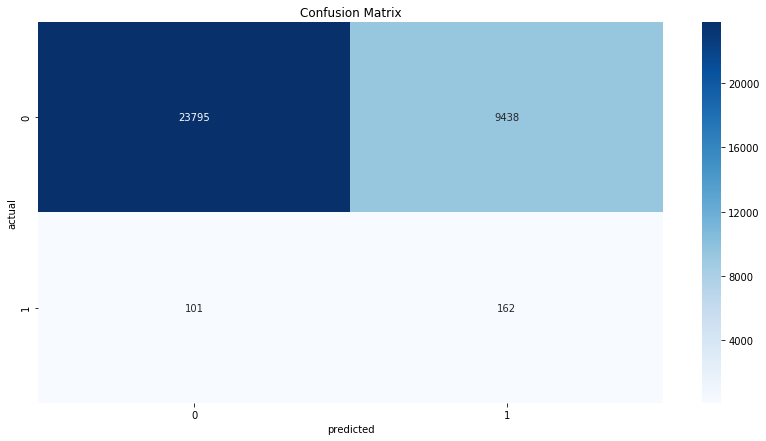

In [219]:
clf_model = RUSBoostClassifier_fit(X, y, random_state=42)

## Fit XGBoost Model

In [220]:
def XGBClassifier_fit(X, y, random_state=42):
    
    rus = RandomUnderSampler(random_state=random_state)
    metrics_results = {}
    
    # train test Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.33, random_state=random_state)

    # undersampling using Random Under Sampling with a class ratio of 1 to 1
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    # fitting the model
    xgb_model = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=5,
                        min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                        objective='binary:logistic',nthread=4,scale_pos_weight=1)
    xgb_model = xgb_model.fit(X_train_res, y_train_res)

    y_test_predicted = xgb_model.predict(X_test)
    y_test_predicted_prob = xgb_model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_test_predicted, normalize=True)
    recall = recall_score(y_test, y_test_predicted, average=None)
    roc_auc = roc_auc_score(y_test, y_test_predicted)
    precision = precision_score(y_test, y_test_predicted, average=None)
    confusion = confusion_matrix(y_test, y_test_predicted)
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    # creating a metrics dictionary
    metrics_results['Accuracy'] = accuracy
    metrics_results['Precision'] = precision
    metrics_results['Recall'] = recall
    metrics_results['ROC AUC'] = roc_auc
    metrics_results['TN'] = TN
    metrics_results['FP'] = FP
    metrics_results['FN'] = FN
    metrics_results['TP'] = TP
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    print('\t\tAccuracy:', metrics_results['Accuracy'])
    print('\t\tPrecision:', metrics_results['Precision'])
    print('\t\tRecall:', metrics_results['Recall'])
    print('\t\tRoc AUC:', metrics_results['ROC AUC'])
    print('\t\tTrue Pos:', TP)
    print('\t\tFalse Pos:', FP)
    print('\t\tTrue Neg:', TN)
    print('\t\tFalse Neg:', FN)
    print('\t\tSensitivity:', sensitivity)
    print('\t\tSpecificity:', specificity)

    cm = [[TN, FP], [FN, TP]]
    plt.figure(figsize=(14,7))
    sns.heatmap(cm,  cmap= 'Blues', annot=True, fmt='1')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    feat_imp = pd.Series(xgb_model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importance', figsize=(12,6), color='blue')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    return xgb_model

		Accuracy: 0.7016658705517077
		Precision: [0.9977298  0.02068966]
		Recall: [0.70089971 0.79847909]
		Roc AUC: 0.7496893977869585
		True Pos: 210
		False Pos: 9940
		True Neg: 23293
		False Neg: 53
		Sensitivity: 0.7984790874524715
		Specificity: 0.7008997081214455


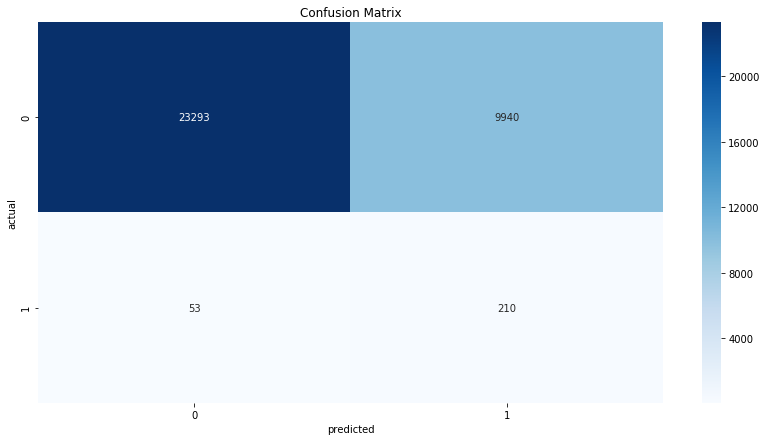

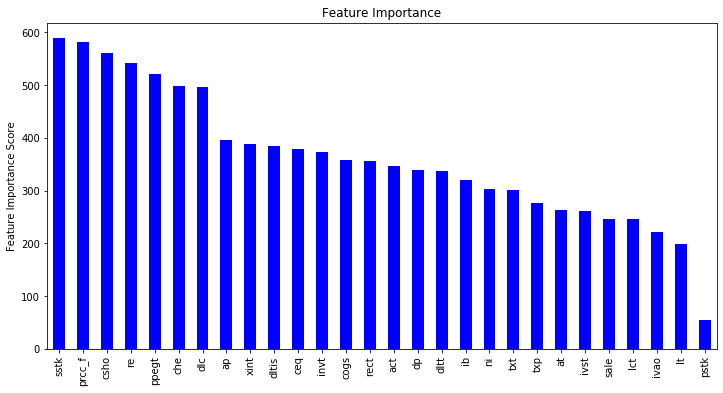

In [221]:
xgb_model = XGBClassifier_fit(X, y, random_state=42)

## Test RUS AdaBoost Model

In [222]:
def RUSBoostClassifier_test(fit_model, X, y):
    
    metrics_results = {}
    y_predicted = fit_model.predict(X)
#     y_predicted = (fit_model.predict_proba(X)[:,1] >= 0.95).astype(bool)
    y_predicted_prob = fit_model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_predicted, normalize=True)
    recall = recall_score(y, y_predicted, average=None)
    roc_auc = roc_auc_score(y, y_predicted)
    precision = precision_score(y, y_predicted, average=None)
    confusion = confusion_matrix(y, y_predicted)
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    # creating a metrics dictionary
    metrics_results['Accuracy'] = accuracy
    metrics_results['Precision'] = precision
    metrics_results['Recall'] = recall
    metrics_results['ROC AUC'] = roc_auc
    metrics_results['TN'] = TN
    metrics_results['FP'] = FP
    metrics_results['FN'] = FN
    metrics_results['TP'] = TP
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    print('\t\tAccuracy:', metrics_results['Accuracy'])
    print('\t\tPrecision:', metrics_results['Precision'])
    print('\t\tRecall:', metrics_results['Recall'])
    print('\t\tRoc AUC:', metrics_results['ROC AUC'])
    print('\t\tTrue Pos:', TP)
    print('\t\tFalse Pos:', FP)
    print('\t\tTrue Neg:', TN)
    print('\t\tFalse Neg:', FN)
    print('\t\tSensitivity:', sensitivity)
    print('\t\tSpecificity:', specificity)

    cm = [[TN, FP], [FN, TP]]
    plt.figure(figsize=(14,7))
    sns.heatmap(cm,  cmap= 'Greens', annot=True, fmt='1')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.show()

    return

		Accuracy: 0.7075475933908046
		Precision: [0.99765057 0.00720472]
		Recall: [0.70810799 0.55952381]
		Roc AUC: 0.6338158979113551
		True Pos: 94
		False Pos: 12953
		True Neg: 31423
		False Neg: 74
		Sensitivity: 0.5595238095238095
		Specificity: 0.7081079862989003


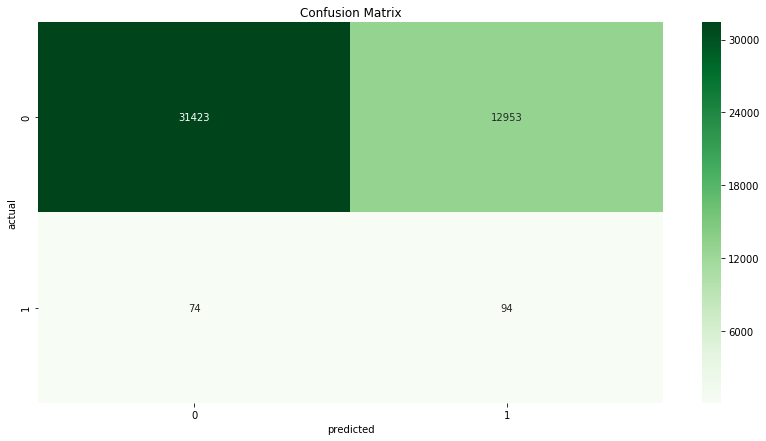

In [223]:
RUSBoostClassifier_test(clf_model, X2, y2)

## Test XGBoost Model

In [224]:
def XGBClassifier_test(fit_model, X, y):
    
    metrics_results = {}
    y_predicted = fit_model.predict(X)
#     y_predicted = (fit_model.predict_proba(X)[:,1] >= 0.95).astype(bool)
    y_predicted_prob = fit_model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_predicted, normalize=True)
    recall = recall_score(y, y_predicted, average=None)
    roc_auc = roc_auc_score(y, y_predicted)
    precision = precision_score(y, y_predicted, average=None)
    confusion = confusion_matrix(y, y_predicted)
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    TP = confusion[1][1]

    # creating a metrics dictionary
    metrics_results['Accuracy'] = accuracy
    metrics_results['Precision'] = precision
    metrics_results['Recall'] = recall
    metrics_results['ROC AUC'] = roc_auc
    metrics_results['TN'] = TN
    metrics_results['FP'] = FP
    metrics_results['FN'] = FN
    metrics_results['TP'] = TP
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    print('\t\tAccuracy:', metrics_results['Accuracy'])
    print('\t\tPrecision:', metrics_results['Precision'])
    print('\t\tRecall:', metrics_results['Recall'])
    print('\t\tRoc AUC:', metrics_results['ROC AUC'])
    print('\t\tTrue Pos:', TP)
    print('\t\tFalse Pos:', FP)
    print('\t\tTrue Neg:', TN)
    print('\t\tFalse Neg:', FN)
    print('\t\tSensitivity:', sensitivity)
    print('\t\tSpecificity:', specificity)

    cm = [[TN, FP], [FN, TP]]
    plt.figure(figsize=(14,7))
    sns.heatmap(cm,  cmap= 'Greens', annot=True, fmt='1')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    feat_imp = pd.Series(fit_model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importance', figsize=(12,6), color='green')
    plt.ylabel('Feature Importance Score')
    plt.show()

    return

		Accuracy: 0.6755118534482759
		Precision: [0.9979365  0.00731135]
		Recall: [0.67568055 0.63095238]
		Roc AUC: 0.6533164644981844
		True Pos: 106
		False Pos: 14392
		True Neg: 29984
		False Neg: 62
		Sensitivity: 0.6309523809523809
		Specificity: 0.6756805480439877


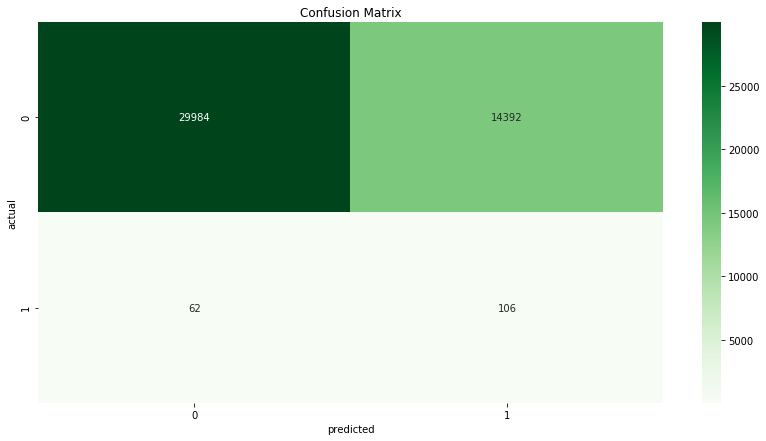

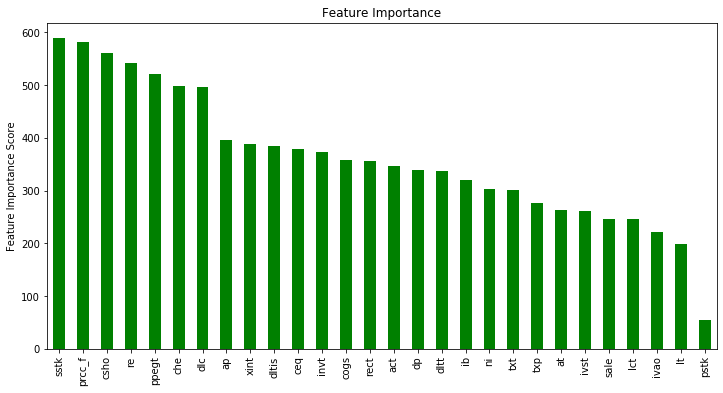

In [225]:
XGBClassifier_test(xgb_model, X2, y2)

In [255]:
y_predicted = pd.Series(xgb_model.predict(X), name='predicted')
y_predicted_prob = pd.DataFrame(data=xgb_model.predict_proba(X), columns=['prb_no_fraud', 'prb_fraud'])

In [304]:
proba_df = y_predicted_prob.join(y_predicted)
proba_df = proba_df.join(y)
proba_df = proba_df.join(df_train[['fyear', 'gvkey']])

In [305]:
proba_df

,prb_no_fraud,prb_fraud,predicted,misstate,fyear,gvkey
0,0.858391,0.141609,0,0,1990,1009
1,0.401314,0.598686,1,0,1990,1011
2,0.985697,0.014303,0,0,1990,1017
3,0.282871,0.717129,1,0,1990,1021
4,0.984004,0.015996,0,0,1990,1028
...,...,...,...,...,...,...
101496,0.914820,0.085180,0,0,2006,277579
101497,0.271147,0.728853,1,0,2006,277846
101498,0.380409,0.619591,1,0,2006,278234
101499,0.344683,0.655317,1,0,2006,278400


In [257]:
proba_df[(proba_df['misstate'] == 0) & (proba_df['predicted'] == 1)].sort_values('prb_fraud', ascending=False).head(5)

,prb_no_fraud,prb_fraud,predicted,misstate
62616,0.000010,0.999990,1,0
64537,0.000041,0.999959,1,0
83966,0.000053,0.999947,1,0
32832,0.000059,0.999941,1,0
99008,0.000064,0.999936,1,0


In [258]:
round(len(proba_df)*.1, ndigits=0)

10150.0

In [259]:
highest_one_p = proba_df.sort_values('prb_fraud', ascending=False).head(10150)

In [260]:
len(highest_one_p[(highest_one_p['predicted'] == 1) & (highest_one_p['misstate'] == 1)])

661

In [261]:
len(highest_one_p[(highest_one_p['predicted'] == 1) & (highest_one_p['misstate'] == 0)])

9489

In [272]:
len(highest_one_p[(highest_one_p['predicted'] == 0) & (highest_one_p['misstate'] == 1)])

0

In [273]:
proba_df.misstate.sum()

796

In [ ]:
for year in years:
    fraud_per_year.append((df[df['fyear'] == year].groupby('gvkey').agg({'misstate':'sum'}).sum()/len(df[df['fyear'] == year].groupby('gvkey').agg({'misstate':'sum'}))*100))